In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

In [27]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'
path_local = '/home/katrin/Documents'

try:
    models = Models.read(f"{path_crab}/standard_model.yml")
    dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')

except:
    models = Models.read(f"{path_local}/{source}/standard_model.yml")
    dataset_standard = MapDataset.read(f'{path_local}/{source}/stacked.fits')

dataset_standard = dataset_standard.downsample(4)
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_standard.models = models
dataset_standard.counts = dataset_standard.npred()

## Varying the Exposure

In [28]:
savefig = False
picformat = 'svg'

bias = 0.1
resolution = 0.8
print(bias)


0.1


In [29]:
infos = np.loadtxt("data/7a_gridd_P_draw_info.txt")
pars = np.loadtxt("data/7a_gridd_P_draw_par.txt")
pars_N = np.loadtxt("data/7a_gridd_P_draw_par_N.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)
resolution_rnds = infos[:N_max,0]
bias_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]

amplitudes_N = pars_N[:N_max,0:2] 
indices_N = pars_N[:N_max,2:4] 
norms_N = pars_N[:N_max,4:6]
tilts_N = pars_N[:N_max,6:8]

2


<IPython.core.display.Javascript object>


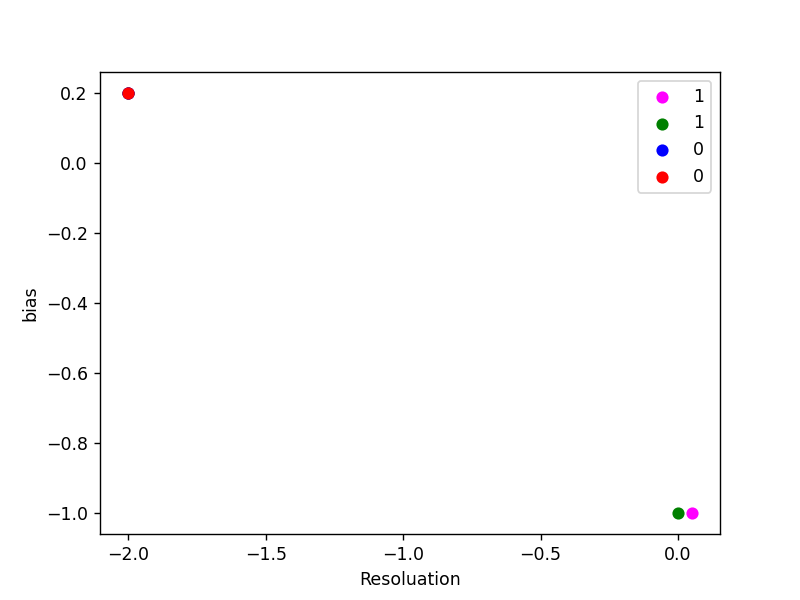

In [30]:
fig = plt.figure()
reds, greens, magentas, blues = 0,0,0,0
for n in range(N):
    if bias_rnds[n]< 0.:
        if resolution_rnds[n] <0.5 and resolution_rnds[n] >0:
            colors_temp = ['magenta', 'lightblue', 'purple', 'lightgrey']
            magentas +=1 
        else:
            colors_temp = ['green', 'lightblue', 'darkgreen', 'grey']
            greens +=1
    else:
        if resolution_rnds[n] >0.5 and resolution_rnds[n] >0:
            colors_temp = ['blue', 'lightblue', 'darkblue', 'lightgrey']
            blues +=1
        else:
            colors_temp = ['red', 'lightblue', 'darkred', 'darkred']
            reds += 1
    if resolution_rnds[n]<0.:
        colors_temp = ['grey']
            
    xs = resolution_rnds[n]
    ys = bias_rnds[n]
    plt.scatter(xs, ys, color =colors_temp[0])
plt.xlabel("Resoluation")
plt.ylabel("bias")
plt.scatter(-2, 0.2, color = 'magenta', label = magentas)
plt.scatter(-2, 0.2, color = 'green', label = greens)
plt.scatter(-2, 0.2, color = 'blue', label = blues)
plt.scatter(-2, 0.2, color = 'red', label = reds)

plt.legend()

<IPython.core.display.Javascript object>


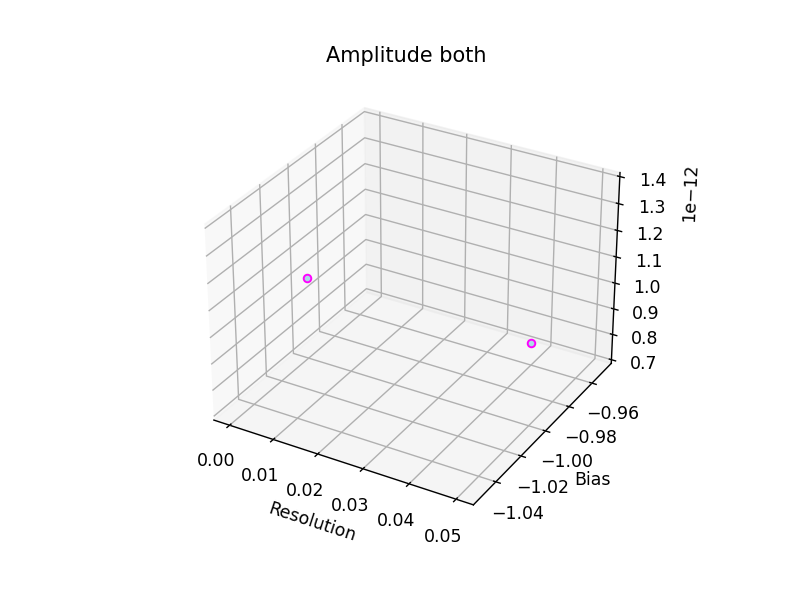

Text(0.5, 0.92, 'Amplitude both ')

In [31]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n in range(N):
    if bias_rnds[n]< 0.:
        if resolution_rnds[n] <0.5:
            colors_temp = ['magenta', 'lightblue', 'purple', 'lightgrey']
        else:
            colors_temp = ['green', 'lightblue', 'darkgreen', 'grey']
    else:
        if resolution_rnds[n] >0.5:
            colors_temp = ['blue', 'lightblue', 'darkblue', 'lightgrey']
        else:
            colors_temp = ['red', 'lightblue', 'darkred', 'darkred']
    
    if resolution_rnds[n] <0:
        alpha = 0.3
        colors_temp = ['grey', 'lightblue', 'darkgrey', 'lightgrey']
    else:
        alpha = 1
    xs = resolution_rnds[n]
    ys = bias_rnds[n]
    zs = amplitudes[n][0]
    ax.scatter(xs, ys, zs, color = colors_temp[0], alpha = alpha)
    zs = amplitudes_N[n][0]
    ax.scatter(xs, ys, zs, color = colors_temp[1], marker = '.', alpha = alpha)
    
    zs = amplitudes[n][0] + amplitudes[n][1]
    #ax.scatter(xs, ys, zs, color = colors_temp[2], alpha = alpha )
    zs = amplitudes_N[n][0] + amplitudes_N[n][1]
    #ax.scatter(xs, ys, zs, color =  colors_temp[3], marker = '.', alpha = alpha)
    
ax.set_ylabel("Bias")
ax.set_xlabel("Resolution")
ax.set_zlim(0.7e-12, 1.4e-12)
ax.set_title("Amplitude both ")

<IPython.core.display.Javascript object>


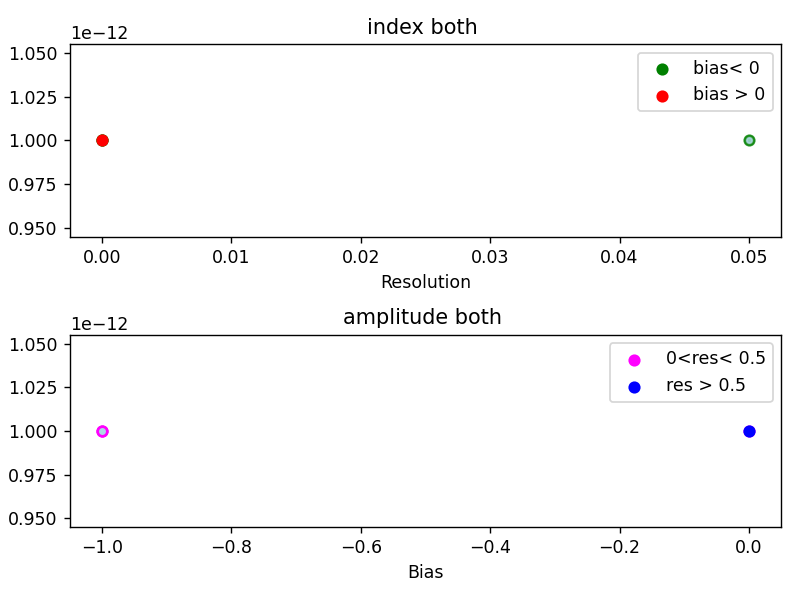

In [32]:

fig, axs = plt.subplots(2,1)

ax = axs[0]
for n in range(N):
    if bias_rnds[n]< 0.:
        colors_temp = ['green', 'lightblue', 'darkgreen', 'grey']
    else:
        colors_temp = ['red', 'lightblue', 'darkred', 'lightgrey']
    if resolution_rnds[n] <0:
        alpha = 0.3
        alpha_err =0.1
        colors_temp = ['grey', 'lightblue', 'darkgrey', 'lightgrey']
    else:
        alpha = 0.8
        alpha_err =0.1
    xs = resolution_rnds[n]
    zs = amplitudes[n][0]
    ax.scatter(xs, zs, color = colors_temp[0], alpha = alpha)
    zs = amplitudes_N[n][0]
    ax.scatter(xs, zs, color = colors_temp[1], marker = '.', alpha = alpha)
    
    zs = amplitudes[n][0] + amplitudes[n][1]
    ax.scatter(xs, zs, color = colors_temp[2], alpha = alpha_err )
    zs = amplitudes_N[n][0] + amplitudes_N[n][1]
    ax.scatter(xs, zs, color = colors_temp[3], marker = '.', alpha = alpha_err)
    
    
ax.scatter(0, 1e-12 , color = 'green', label = "bias< 0")
ax.scatter(0, 1e-12 , color = 'red', label = "bias > 0")    
ax.set_xlabel("Resolution")
ax.legend()
ax.set_title("index both ")


ax = axs[1]
for n in range(N):
    if resolution_rnds[n]< 0.5:
        colors_temp = ['magenta', 'lightblue', 'purple', 'lightgrey']
    else:
        colors_temp = ['blue', 'lightblue', 'darkblue', 'lightgrey']
    if resolution_rnds[n] <0:
        alpha = 0.1
        alpha_err =0.1
        colors_temp = ['grey', 'lightblue', 'darkgrey', 'lightgrey']
    else:
        alpha = 1
        alpha_err = 0.1

    ax = axs[1]
    ys = bias_rnds[n]
    zs = amplitudes[n][0]
    ax.scatter( ys, zs, color = colors_temp[0], alpha = alpha)
    zs = amplitudes_N[n][0]
    ax.scatter( ys, zs, color = colors_temp[1], marker = '.', alpha = alpha)
    zs = amplitudes[n][0] + amplitudes[n][1]
    ax.scatter( ys, zs, color = colors_temp[2], alpha = alpha_err )
    zs = amplitudes_N[n][0] + amplitudes_N[n][1]
    ax.scatter( ys, zs, color = colors_temp[3], marker = '.', alpha = alpha_err)
ax.scatter(0, 1e-12, color = 'magenta', label = "0<res< 0.5")
ax.scatter(0, 1e-12, color = 'blue', label = "res > 0.5")

ax.set_xlabel("Bias")
ax.legend()
ax.set_title("amplitude both ")
plt.tight_layout()

<IPython.core.display.Javascript object>


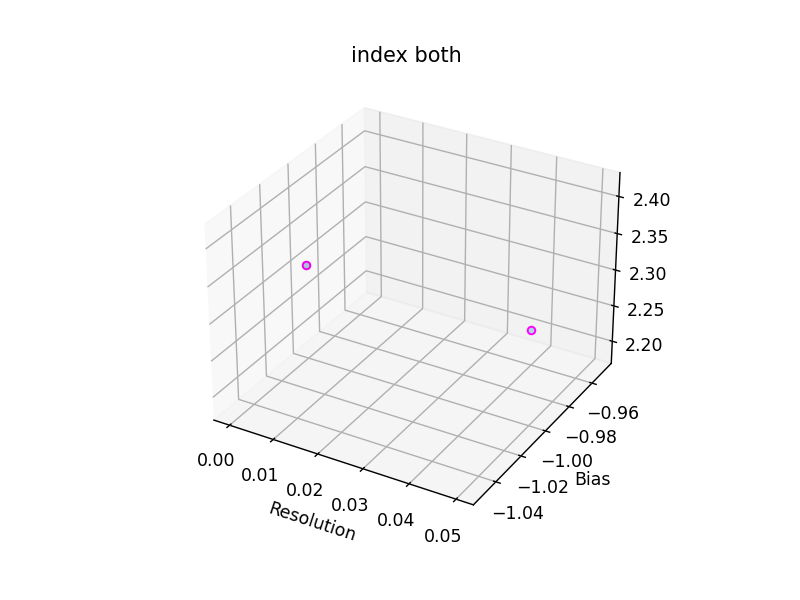

Text(0.5, 0.92, 'index both ')

In [22]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n in range(N):
    if bias_rnds[n]< 0.:
        if resolution_rnds[n] <0.5:
            colors_temp = ['magenta', 'lightblue', 'purple', 'lightgrey']
        else:
            colors_temp = ['green', 'lightblue', 'darkgreen', 'grey']
    else:
        if resolution_rnds[n] >0.5:
            colors_temp = ['blue', 'lightblue', 'darkblue', 'lightgrey']
        else:
            colors_temp = ['red', 'lightblue', 'darkred', 'darkred']
    
    if resolution_rnds[n] <0:
        alpha = 0.3
        alpha_err = 0.1
        colors_temp = ['grey', 'lightblue', 'darkgrey', 'lightgrey']
    else:
        alpha = 1
        alpha_err = 0.1
        
    xs = resolution_rnds[n]
    ys = bias_rnds[n]
    zs = indices[n][0]
    ax.scatter(xs, ys, zs, color = colors_temp[0], alpha = alpha)
    zs = indices_N[n][0]
    ax.scatter(xs, ys, zs, color = colors_temp[1], marker = '.', alpha = alpha)
    
    zs = indices[n][0] + indices[n][1]
    ax.scatter(xs, ys, zs, color = colors_temp[2], alpha = alpha_err )
    zs = indices_N[n][0] + indices_N[n][1]
    ax.scatter(xs, ys, zs, color =  colors_temp[3], marker = '.', alpha = alpha_err)
    
ax.set_ylabel("Bias")
ax.set_xlabel("Resolution")

ax.set_title("index both ")

<IPython.core.display.Javascript object>


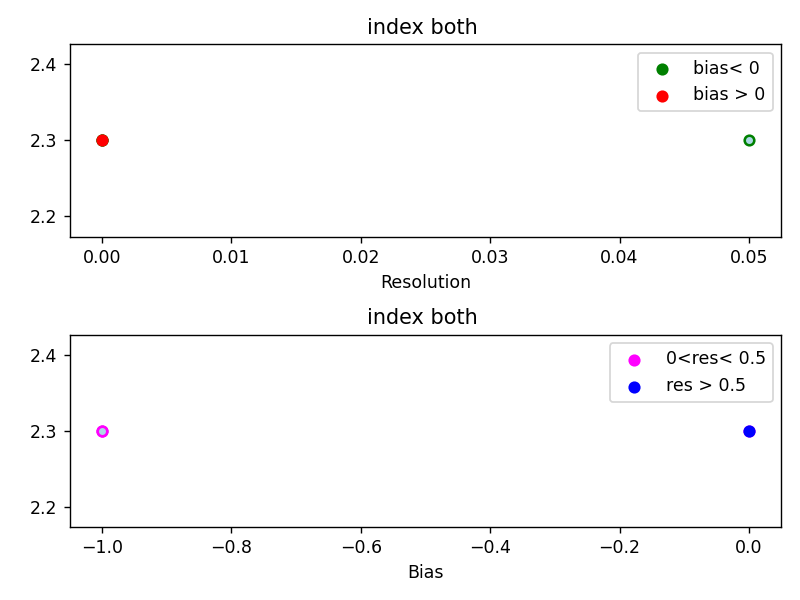

In [23]:

fig, axs = plt.subplots(2,1)

ax = axs[0]
for n in range(N):
    if bias_rnds[n]< 0.:
        colors_temp = ['green', 'lightblue', 'darkgreen', 'grey']
    else:
        colors_temp = ['red', 'lightblue', 'darkred', 'lightgrey']
    if resolution_rnds[n] <0:
        alpha = 0.3
        alpha_err = 0.1
        colors_temp = ['grey', 'lightblue', 'darkgrey', 'lightgrey']
    else:
        alpha = 1
        alpha_err = 0.1
        
    xs = resolution_rnds[n]
    zs = indices[n][0]
    ax.scatter(xs, zs, color = colors_temp[0], alpha = alpha)
    zs = indices_N[n][0]
    ax.scatter(xs, zs, color = colors_temp[1], marker = '.', alpha = alpha)
    
    zs = indices[n][0] + indices[n][1]
    ax.scatter(xs, zs, color = colors_temp[2], alpha = alpha_err )
    zs = indices_N[n][0] + indices_N[n][1]
    ax.scatter(xs, zs, color = colors_temp[3], marker = '.', alpha = alpha_err)
    
    
ax.scatter(0, 2.3 , color = 'green', label = "bias< 0")
ax.scatter(0, 2.3 , color = 'red', label = "bias > 0")    
ax.set_xlabel("Resolution")
ax.legend()
ax.set_title("index both ")


ax = axs[1]
for n in range(N):
    if resolution_rnds[n]< 0.5:
        colors_temp = ['magenta', 'lightblue', 'purple', 'lightgrey']
    else:
        colors_temp = ['blue', 'lightblue', 'darkblue', 'lightgrey']
    if resolution_rnds[n] <0:
        alpha = 0.1
        colors_temp = ['grey', 'lightblue', 'darkgrey', 'lightgrey']
    else:
        alpha = 1

    ys = bias_rnds[n]
    zs = indices[n][0]
    ax.scatter( ys, zs, color = colors_temp[0], alpha = alpha)
    zs = indices_N[n][0]
    ax.scatter( ys, zs, color = colors_temp[1], marker = '.', alpha = alpha)
    zs = indices[n][0] + indices[n][1]
    ax.scatter( ys, zs, color = colors_temp[2], alpha = alpha_err )
    zs = indices_N[n][0] + indices_N[n][1]
    ax.scatter( ys, zs, color = colors_temp[3], marker = '.', alpha = alpha_err)
ax.scatter(0, 2.3 , color = 'magenta', label = "0<res< 0.5")
ax.scatter(0, 2.3 , color = 'blue', label = "res > 0.5")

ax.set_xlabel("Bias")
ax.legend()
ax.set_title("index both ")
plt.tight_layout()

## Bias = 0 

<IPython.core.display.Javascript object>


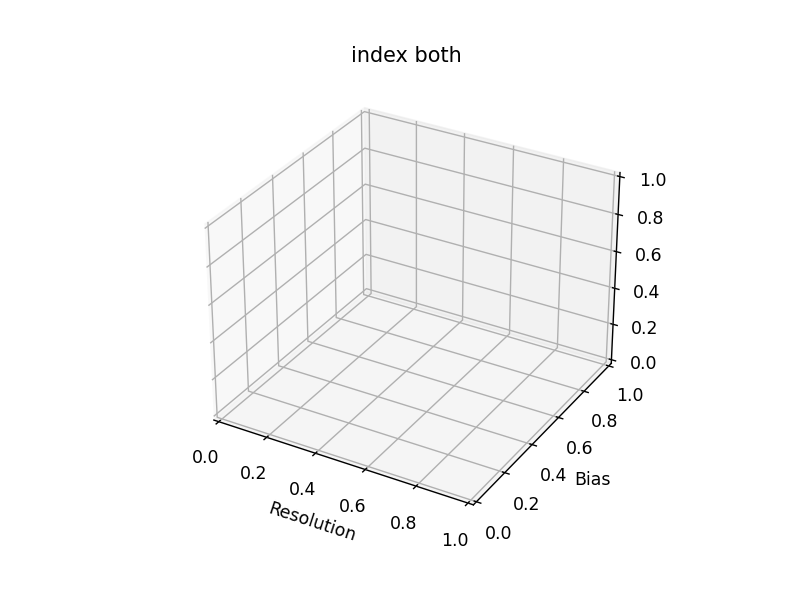

Text(0.5, 0.92, 'index both ')

In [25]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n in range(N):
    if bias_rnds[n]== 0. and  resolution_rnds[n] >0.:
        colors_temp = ['green', 'blue', 'lightgreen', 'black']
        alpha_err = 0.6
        xs = resolution_rnds[n]
        ys = bias_rnds[n]
        zs = indices[n][0]
        ax.scatter(xs, ys, zs, color = colors_temp[0], alpha = alpha)
        zs = indices_N[n][0]
        ax.scatter(xs, ys, zs, color = colors_temp[1], marker = 'x', alpha = alpha)

        zs = indices[n][0] + indices[n][1]
        ax.scatter(xs, ys, zs, color = colors_temp[2], alpha = alpha_err )
        zs = indices_N[n][0] + indices_N[n][1]
        ax.scatter(xs, ys, zs, color =  colors_temp[3], marker = 'x', alpha = alpha_err)

ax.set_ylabel("Bias")
ax.set_xlabel("Resolution")

ax.set_title("index both ")

<IPython.core.display.Javascript object>


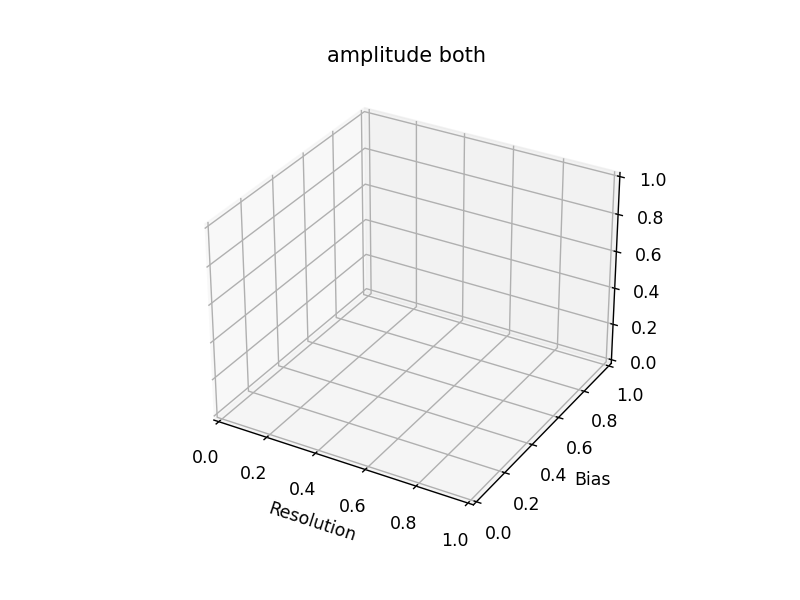

Text(0.5, 0.92, 'amplitude both ')

In [26]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n in range(N):
    if bias_rnds[n]== 0. and  resolution_rnds[n] >0.:
        colors_temp = ['magenta', 'blue', 'pink', 'black']
        
        xs = resolution_rnds[n]
        ys = bias_rnds[n]
        zs = amplitudes[n][0]
        ax.scatter(xs, ys, zs, color = colors_temp[0], alpha = alpha)
        zs = amplitudes_N[n][0]
        ax.scatter(xs, ys, zs, color = colors_temp[1], marker = 'x', alpha = alpha)

        zs = amplitudes[n][0] + amplitudes[n][1]
        ax.scatter(xs, ys, zs, color = colors_temp[2], alpha = alpha_err )
        zs = amplitudes_N[n][0] + amplitudes_N[n][1]
        ax.scatter(xs, ys, zs, color =  colors_temp[3], marker = 'x', alpha = alpha_err)

ax.set_ylabel("Bias")
ax.set_xlabel("Resolution")

ax.set_title("amplitude both ")